<a href="https://colab.research.google.com/github/hichem19alg/Python/blob/master/Tensorflow_CNN_with_Quickdraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#for images
import PIL
#creating dir
import os
import urllib.request

In [ ]:
#creating dir for data
os.mkdir('data')

In [ ]:
#Def for downloading images from quickdraw
def download(class_names, test_split = 0.2, max_items_per_class = 5000):
  root = 'data'
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in class_names:
    path = base+c+'.npy'
    urllib.request.urlretrieve(path, f'{root}/{c}.npy')
  
  #initialize variables 
  x = np.empty([0, 784])
  y = np.empty([0])

  #load each data file 
  for idx, file in enumerate(class_names):
      data = np.load(f'{root}/{file}.npy')
      data = data[0: max_items_per_class, :]
      labels = np.full(data.shape[0], idx)

      x = np.concatenate((x, data), axis=0)
      y = np.append(y, labels)

  data = None
  labels = None

  #randomize the dataset 
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  #reshape and inverse the colors 
  x = 255 - np.reshape(x, (x.shape[0], 28, 28))

  #separate into training and testing 
  test_size  = int(x.shape[0]/100*(test_split*100))

  x_test = x[0:test_size, :]
  y_test = y[0:test_size]

  x_train = x[test_size:x.shape[0], :]
  y_train = y[test_size:y.shape[0]]
  
  return x_train, y_train, x_test, y_test

In [ ]:
#load images
class_names = ['table', 'eyeglasses', 'sun','apple', 'moon', 'face', 'book', 'fork' , 'pizza', 'hand']
train_data, train_targets, test_data, test_tagets, = download(class_names, max_items_per_class = 10000)
print('train_data.shape = ',train_data.shape)
print('train_targets.shape = ',train_targets.shape)
print('test_data.shape = ',test_data.shape)
print('test_tagets.shape = ',test_tagets.shape)

In [ ]:
#reduce the images to 10000 for train and 2000 for test
images_train, targets_train, images_test, targets_test = train_data, train_targets, test_data, test_tagets

In [ ]:
images_train = images_train/255
images_test = images_test/255

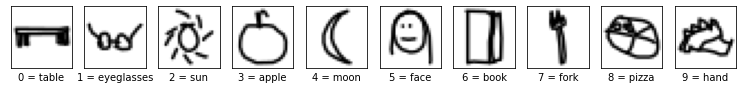

In [ ]:
# printing all the targets with thier images
unique_targets= np.unique(targets_train)
f, axarr = plt.subplots(1, len(unique_targets)) #Subplot methode to shwo many pictures
f.set_figheight(13)
f.set_figwidth(13)

for i in range(len(unique_targets)):
  for j in range(0, len(targets_train)):
    if (i == targets_train[j]):
      axarr[i].imshow(images_train[j] , cmap="gray") # cmap="binary" to show in white and black
      axarr[i].set_xlabel('{0} = {1}'.format(i, class_names[i]) ) #,size=9
      axarr[i].set_xticks([])
      axarr[i].set_yticks([])
      break

In [ ]:
#Reshaphe and scale images to the right shape
scaler = StandardScaler()
images_train = scaler.fit_transform(images_train.reshape(-1, 28*28))
images_test = scaler.fit_transform(images_test.reshape(-1, 28*28))

images_train = images_train.reshape(-1, 28,28 , 1)
images_test= images_test.reshape(-1, 28,28 , 1)

print('images_train.shape = ',images_train.shape)
print('images_test.shape = ',images_test.shape)
print ('images_train[0:1].shape = ', images_train[0:1].shape)

images_train.shape =  (80000, 28, 28, 1)
images_test.shape =  (20000, 28, 28, 1)
images_train[0:1].shape =  (1, 28, 28, 1)


In [ ]:
#using tf.dataset to manipulate data easilly
#data_train = tf.data.Dataset.from_tensor_slices((images_train , targets_train)) #using tuple
#data_test = tf.data.Dataset.from_tensor_slices((images_test , targets_test))

In [ ]:
#creat model
model = tf.keras.models.Sequential()
#add  operation to our model
model.add(tf.keras.layers.Conv2D(16, 3, padding= 'same', activation = 'relu') )
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, 3,padding= 'same', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(64, 3, padding= 'same',  activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(len(class_names), activation = 'softmax'))
model_output = model.predict(images_train[0:1])
print(model_output)

[[0.10486057 0.11480393 0.12678356 0.11389198 0.09439433 0.0585086
  0.07448698 0.11686894 0.13463964 0.0607615 ]]


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 64)          0

In [ ]:
#compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
#train the model
history = model.fit(images_train,targets_train, epochs=10, batch_size= 32, validation_split= 0.2)

Epoch 1/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.4250 - accuracy: 0.8756 - val_loss: 0.2644 - val_accuracy: 0.9222
Epoch 2/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.2441 - accuracy: 0.9263 - val_loss: 0.2305 - val_accuracy: 0.9302
Epoch 3/10
2000/2000 [==============================] - 53s 26ms/step - loss: 0.2046 - accuracy: 0.9371 - val_loss: 0.2220 - val_accuracy: 0.9349
Epoch 4/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.1773 - accuracy: 0.9440 - val_loss: 0.2137 - val_accuracy: 0.9366
Epoch 5/10
2000/2000 [==============================] - 51s 25ms/step - loss: 0.1563 - accuracy: 0.9509 - val_loss: 0.2028 - val_accuracy: 0.9387
Epoch 6/10
2000/2000 [==============================] - 50s 25ms/step - loss: 0.1426 - accuracy: 0.9543 - val_loss: 0.2056 - val_accuracy: 0.9384
Epoch 7/10
2000/2000 [==============================] - 49s 25ms/step - loss: 0.1296 - accuracy: 0.9585 - val_loss: 0.2005 -

<function matplotlib.pyplot.show>

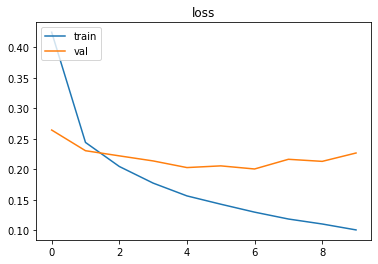

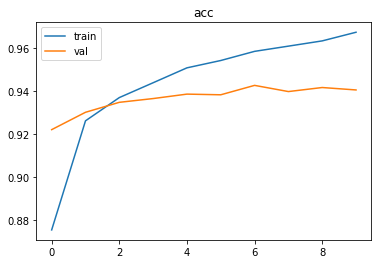

In [ ]:
#tracer les courbes de train
loss_curve = history.history['loss']
acc_curve = history.history['accuracy']

loss_val_curve = history.history['val_loss']
acc_val_curve = history.history['val_accuracy']

f1 = plt.figure(1)
plt.plot(loss_curve, label='train')
plt.plot(loss_val_curve , label='val')
plt.legend(loc='upper left')
plt.title('loss')

f2 = plt.figure(2)
plt.plot(acc_curve , label='train')
plt.plot(acc_val_curve , label='val')
plt.legend(loc='upper left')
plt.title('acc')
plt.show

In [ ]:
start_test = 0
end_test = len(images_test)
result = model.evaluate(images_test[start_test:end_test], targets_test[start_test:end_test])
print(round(result[1]*(end_test - start_test)), 'good result from : ', (end_test - start_test))

625/625 [==============================] - 5s 9ms/step - loss: 0.2075 - accuracy: 0.9457
18914 good result from :  20000


In [ ]:
#save model
model.save('simple_nn.h5')

In [ ]:
#charge model
my_model = tf.keras.models.load_model('simple_nn.h5')

In [ ]:
#test on the test_data (images_test and targets_test)
rand = np.random.randint(len(images_test)-1)
my_image = images_test[rand:rand+1]
my_target = targets_test[rand:rand+1]
predict = my_model.predict(my_image)
print('Predict of image N° {} : {}-> {}'. format(rand,np.argmax(predict), class_names[np.argmax (predict)]))
print('Result  of image N° {} : {}-> {}'. format(rand,int(my_target), class_names[int(my_target)] ))

Predict of image N° 7468 : 6-> book
Result  of image N° 7468 : 6-> book


In [ ]:
# Google code for camera capture
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import files

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Saving Nouvelle image bitmap.bmp to Nouvelle image bitmap.bmp




 Predict of Nouvelle image bitmap.bmp : 41 % moon


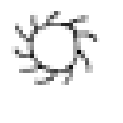

In [ ]:
  #Test model on camera
  # take a picture
#filename = take_photo() 
  #upload a picture from local
filename = list(files.upload().keys())[0]

#print('Saved to {}'.format(filename))

image = PIL.Image.open(filename).convert('L')
image = np.array(image.resize((28, 28)))
image = image/255
image = image.reshape(-1, 28,28 , 1)
fig = plt.figure(1, figsize= (2,2))
plt.imshow(image.reshape(28,28), cmap= 'gray')
plt.axis("off")

plt.show

predict = my_model.predict(image)
print('\n\n\n\n Predict of {} : {} % {}'. format(filename, int(np.max(predict)*100), class_names[np.argmax (predict)]))